# Map of Gaia

- Sylvie Dagoret-Campagne
- affiliation IJCLab/IN2P3/CNRS
- creation date : 2022/09/18


https://gaia-dpci.github.io/GaiaXPy-website/tutorials/Calibrator%20tutorial.html

https://gaia-dpci.github.io/GaiaXPy-website/tutorials/Converter%20tutorial.html

In [1]:
# Import the tool
from gaiaxpy import convert,calibrate, plot_spectra
import numpy as np
from astroquery.gaia import Gaia

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import healpy as hp
from healpy.newvisufunc import projview, newprojplot

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

from astropy.coordinates import Angle
from astropy import units as u


plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['lines.linewidth'] = 2


from astropy import units as u

In [3]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines,calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy import interpolate
from scipy.signal import savgol_filter

# Read tables using Gaia

In [5]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 

In [6]:
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')

Retrieving table 'gaiadr3.gaia_source'


In [7]:
for column in gaiadr3_table.columns:
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

In [8]:
def build_myQuery_nocut(bmax,rmax,bmin=5,rmin=5,nmax=1000):
    query_select_str = f"select TOP {nmax} source_id, ra,dec,phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source"
    query_where_str1 = f"where phot_bp_mean_mag > {bmin} and phot_bp_mean_mag < {bmax} and phot_rp_mean_mag > {rmin} and phot_rp_mean_mag < {rmax}" 
    query_where_str2 = f"and has_xp_continuous = \'True\'"
    
    query_str = query_select_str + " " + query_where_str1 + " " + query_where_str2
    return query_str

In [9]:
def build_myQuery(bmax,rmax,bmin=5,rmin=5, ramin=0,ramax=360.,decmin=-90,decmax=0,nmax=1000):
    query_select_str = f"select TOP {nmax} source_id, ra,dec,phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source"
    query_where_str1 = f"where dec > {decmin} and dec < {decmax} and ra > {ramin} and ra < {ramax}"
    query_where_str2 = f" and phot_bp_mean_mag > {bmin} and phot_bp_mean_mag < {bmax} and phot_rp_mean_mag > {rmin} and phot_rp_mean_mag < {rmax}" 
    query_where_str3 = f"and has_xp_continuous = \'True\'"
    
    query_str = query_select_str + " " + query_where_str1 + " " + query_where_str2 + " " + query_where_str3
    return query_str

In [10]:
#query_input = build_myQuery(10,10,bmin=5,rmin=5, ramin=0,ramax=360.,decmin=-90,decmax=0,nmax=500000)
query_input = build_myQuery_nocut(10,10,bmin=5,rmin=5,nmax=1000000)

In [11]:
query_input 

"select TOP 1000000 source_id, ra,dec,phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source where phot_bp_mean_mag > 5 and phot_bp_mean_mag < 10 and phot_rp_mean_mag > 5 and phot_rp_mean_mag < 10 and has_xp_continuous = 'True'"

In [12]:
job = Gaia.launch_job(query=query_input)
results = job.get_results()

In [13]:
results

source_id,ra,dec,phot_bp_mean_mag,phot_rp_mean_mag
,deg,deg,mag,mag
int64,float64,float64,float32,float32
5937182165220973312,250.32171790439398,-51.39721173654795,7.607164,7.5970407
5937183024214130304,250.18507947208107,-51.477673785228106,6.3795276,5.939466
2263117434765370112,295.04247200662206,70.15936207847098,9.418787,8.099077
2263119290191145984,295.2710527717257,70.2211934478967,9.947235,7.468119
2270005772034166912,317.6651905147883,67.99519173721565,9.581775,7.9053946
2266328077437211392,279.76972181965147,72.95954665403313,7.577563,6.3861227
2263154676423725184,293.5731618494643,70.2596639819731,7.7921877,7.6377497
2263157257701929088,294.05472276977366,70.28483292745604,9.511691,8.296786


In [14]:
NSIDE = 128
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True)/60 
    )
)
print("Pixel area: %.2f square degrees" % hp.nside2pixarea(NSIDE, degrees=True))
NPIX = hp.nside2npix(NSIDE)
print(f"npix = {NPIX}")

Approximate resolution at NSIDE 128 is 0.46 deg
Pixel area: 0.21 square degrees
npix = 196608


In [15]:
ra= results["ra"]
dec= results["dec"]

In [16]:
thetas = np.pi/2 - Angle(dec,unit=u.degree).rad

In [17]:
phis= Angle(ra,unit=u.degree).rad

Text(0.5, 0, 'phis')

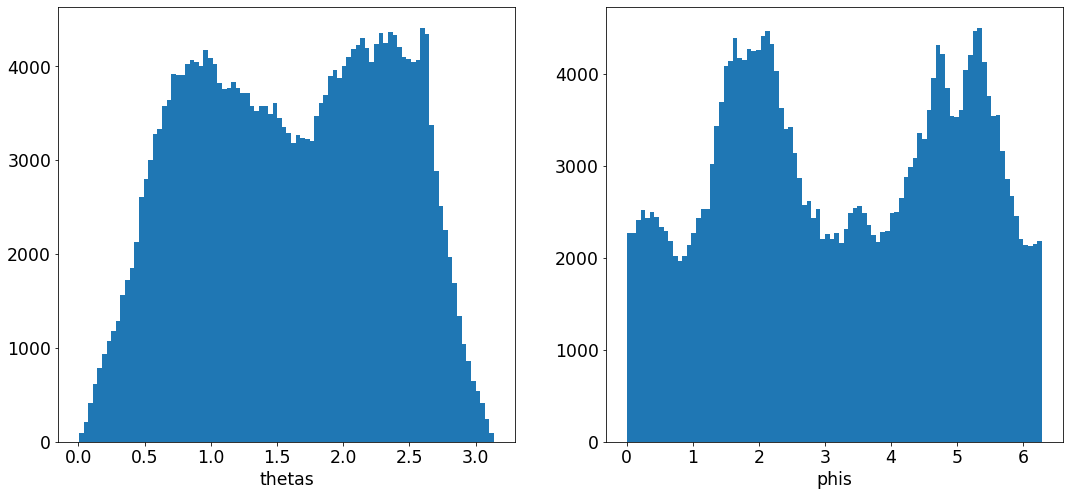

In [18]:
fig=plt.figure(figsize=(18,8))
ax=fig.add_subplot(1,2,1)
ax.hist(thetas,90);
ax.set_xlabel("thetas")
ax=fig.add_subplot(1,2,2)
ax.hist(phis,90);
ax.set_xlabel("phis")

In [19]:
indices = hp.ang2pix(NSIDE, thetas, phis)
bincounts = np.bincount(indices)

Text(0.5, 0, 'n')

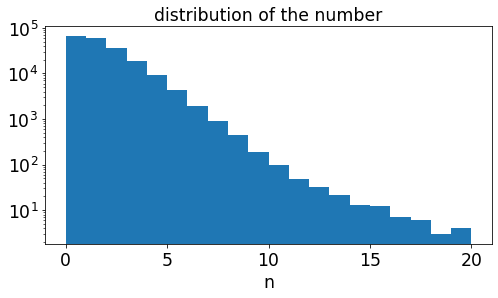

In [20]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(bincounts,20,(0,20));
ax.set_yscale("log")
ax.set_title("distribution of the number")
ax.set_xlabel("n")

In [21]:
hpxmap = np.zeros(NPIX)
np.add.at(hpxmap,indices, 1.0)

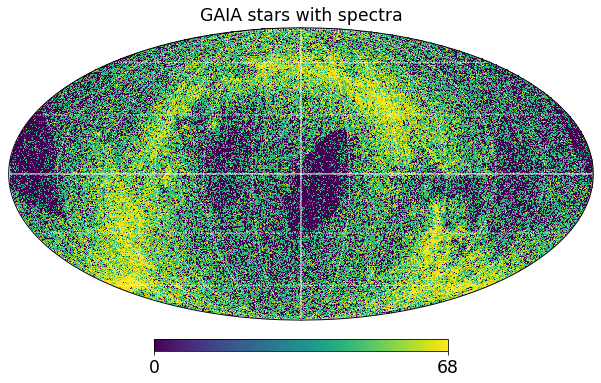

In [22]:
hp.mollview(hpxmap,norm="hist" ,title="GAIA stars with spectra",cmap="viridis")
hp.graticule(color="w")

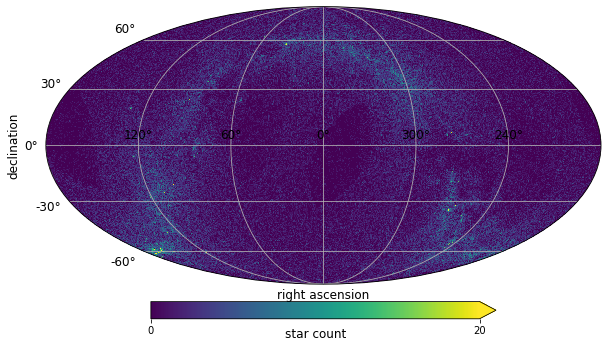

In [31]:
projview(
    hpxmap,
    coord=["G"],
    graticule=True,
    graticule_labels=True,
    unit="star count",
    xlabel="right ascension",
    ylabel="declination",
    cb_orientation="horizontal",
    projection_type="mollweide",
    min=0,
    max=20,
);

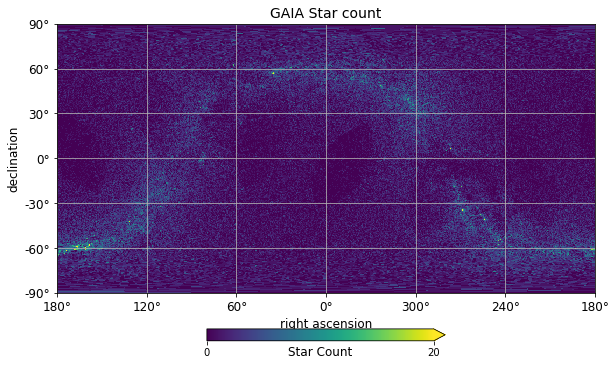

In [34]:
projview(
    hpxmap,
    coord=["G"],
    graticule=True,
    graticule_labels=True,
    unit="Star Count",
    xlabel="right ascension",
    ylabel="declination",
    cb_orientation="horizontal",
    projection_type="cart",
    title="GAIA Star count",
    min=0,
    max=20,
);


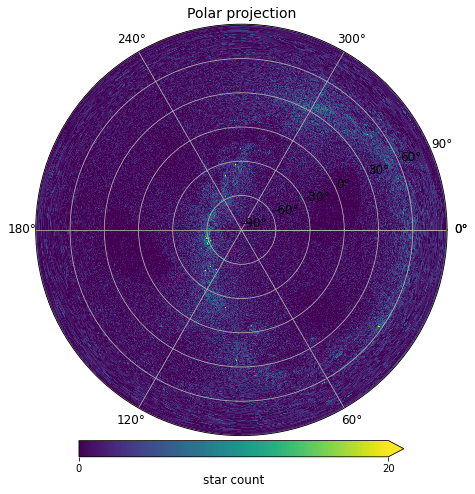

In [36]:
projview(
    hpxmap,
    coord=["G"],
    graticule=True,
    graticule_labels=True,
    unit="star count",
    cb_orientation="horizontal",
    projection_type="polar",
    title="Polar projection",
    min=0,
    max=20,
);

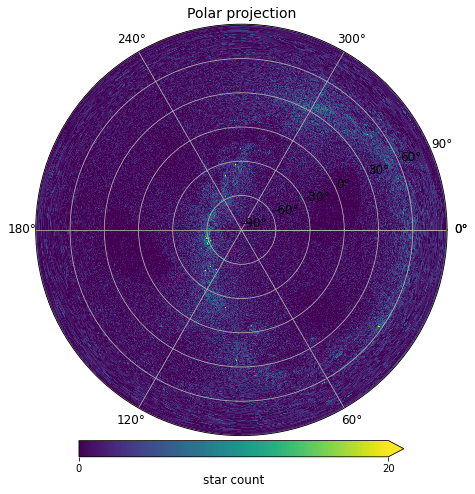

In [37]:
projview(
    hpxmap,
    coord=["G"],
    graticule=True,
    graticule_labels=True,
    flip="astro",
    unit="star count",
    cb_orientation="horizontal",
    projection_type="polar",
    title="Polar projection",
    min=0,
    max=20,
);

In [24]:
LMAX = 3*NSIDE-1 
cl = hp.anafast(hpxmap, lmax=LMAX)
ell = np.arange(len(cl))

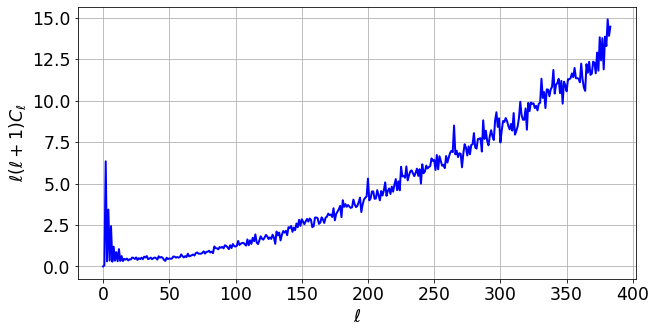

In [25]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
ax.plot(ell, ell * (ell + 1) * cl,'b-')
ax.set_xlabel("$\ell$")
ax.set_ylabel("$\ell(\ell+1)C_{\ell}$")
ax.grid()